In [124]:
import numpy as np
import quantecon as qe
import matplotlib.pyplot as plt
from numba import njit, prange, vectorize

In [125]:
# make this 'full_run' if you want to go with full grid sizes
param_set = 'full_run'

In [126]:
if param_set == 'quick_run':
    agrid_size = 30
    ygrid_size = 30
    xgrid_size = 45
elif param_set == 'full_run':
    agrid_size = 64
    ygrid_size = 46
    xgrid_size = 60

In [127]:
class borrower():

    def __init__(self,
                 sigma = 2,        # inverse intertemporal elasticity
                 r = 0.03,         # rate on assets
                 beta = 0.93,      # discount rate
                 rmmin = 0.05,     # mortgage rate min
                 rmmax = 0.06,     # mortgage rate max
                 rmsize = 2,       # number of rms
                 gamma = 0.8,      # ltv ratio
                 mu = 0.025,       # house price growth (which is equal to income growth)
                 xmin= -5,         # inverse accumulated equity
                 xmax = 0.45,
                 xsize = xgrid_size,
                 amin = 0,
                 amax = 1,
                 asize = agrid_size,
                 ymin = -0.5,
                 ymax = 0.5,
                 ysize = ygrid_size,
                 sigmay = 0.1,
                 sigmap = 0.065,
                 yshocksize = 3,
                 pshocksize = 3,
                 Fnodes = np.array([0.105, .052]),
                 probF = np.array([0.875, 0.125]),
                 ):

        # assigning paramters to "self"

        (self.sigma, self.r, self.beta, self.rmmin, 
        self.rmmax, self.rmsize, self.gamma, self.mu, 
        self.xmin, self.xmax, self.xsize, self.amin, 
        self.amax, self.asize, self.ymin, self.ymax, 
        self.ysize, self.sigmay, self.sigmap, self.yshocksize, 
        self.pshocksize, self.Fnodes, self.probF) = (sigma, r, beta, rmmin, rmmax, 
        rmsize, gamma, mu, xmin, xmax, xsize, amin, amax, asize, ymin, ymax, 
        ysize, sigmay, sigmap, yshocksize, pshocksize, Fnodes, probF)

        # getting grids
        
        rmnodes = self.rmnodes = np.linspace(rmmin, rmmax, rmsize)
        anodes  = self.anodes = np.linspace(amin, amax, asize)
        
        xnodes = np.linspace(xmin, xmax, xsize)
        ynodes = np.linspace(ymin, ymax, ysize)

        # getting grids and probabilities for shocks
        
        mc_y = qe.tauchen(0, sigmay, n=yshocksize)
        self.probyshock = probyshock = mc_y.P[0, :]
        self.yshocknodes = yshocknodes = mc_y.state_values
        self.probyshock_cum = probyshock_cum = np.cumsum(self.probyshock)
        
        mc_p = qe.tauchen(0, sigmap, n=pshocksize)
        self.probpshock = probpshock = mc_p.P[0, :]
        self.pshocknodes = pshocknodes = mc_p.state_values
        self.probpshock_cum = probpshock_cum= np.cumsum(self.probpshock)

        # defining the location of the lowest value of x
        # (used when constructing refinance value function)
        self.xreset = np.argmin(np.abs(xnodes))

        # == creating vectors to find closest match after a shock for a, x and y == #
        # These are index values for a given shock and a given level of the variable
        # For example, for a given shock and a given asset value, where is the closest
        # recorded asset value in my grid which corresponds to the resulting asset value
        # from the equation

        xnearest = np.empty((xsize, pshocksize), dtype=int)
        for i in range(xsize):
            for j in range(pshocksize):
                xnearest[i, j] = int(np.argmin(np.abs((xnodes[i] - mu - pshocknodes[j]) - xnodes)))

        anearest = np.empty((asize, pshocksize), dtype=int)
        for i in range(asize):
            for j in range(pshocksize):
                anearest[i, j] = int(np.argmin(np.abs((anodes[i]*np.exp(-mu-pshocknodes[j])) - anodes)))

        ynearest = np.empty((ysize, pshocksize, yshocksize), dtype=int)
        for i in range(ysize):
            for j in range(pshocksize):
                for k in range(yshocksize):
                    ynearest[i,j,k] = int(np.argmin(np.abs((ynodes[i]+yshocknodes[k]-pshocknodes[j]) - ynodes)))

        self.xnearest, self.anearest, self.ynearest = xnearest, anearest, ynearest
        
        # "unlogging" x and y nodes
        self.xnodes = np.exp(xnodes)
        self.ynodes = np.exp(ynodes)


    def unpack_params(self):

        # returns all relevant objects on call
        return (self.sigma, self.r, self.beta, self.rmmin, 
                self.rmmax, self.rmsize, self.gamma, self.mu, 
                self.xmin, self.xmax, self.xsize, self.amin, 
                self.amax, self.asize, self.ymin, self.ymax, 
                self.ysize, self.sigmay, self.sigmap, self.yshocksize, 
                self.pshocksize, self.Fnodes, self.probF,
                self.yshocknodes, self.pshocknodes, 
                self.rmnodes, self.xnodes, self.anodes, 
                self.ynodes, self.probyshock, self.probyshock_cum, 
                self.probpshock, self.probpshock_cum, self.xreset, 
                self.xnearest, self.anearest, self.ynearest)
    
def operator_factory(agent):
    
    (sigma, r, beta, rmmin, rmmax, rmsize, 
     gamma, mu, xmin, xmax, xsize, amin, 
     amax, asize, ymin, ymax, ysize, sigmay, 
     sigmap, yshocksize, pshocksize, Fnodes, 
     probF, yshocknodes, pshocknodes, rmnodes, 
     xnodes, anodes, ynodes, probyshock, 
     probyshock_cum, probpshock, probpshock_cum, 
     xreset, xnearest, anearest, ynearest) = agent.unpack_params()
    

    @vectorize
    def u(c, sigma):
        '''
        CRRA utility
        '''
        if c < 1e-10:
            return -np.inf
        elif sigma == 1:
            return np.log(c)
        else:
            return (c**(1 - sigma))/(1 - sigma)




    @njit(parallel = True)
    def T(vold, vrefi, vnorefi, vrefi_out, vnorefi_out, pol_refi, pol_norefi):
        '''
        bellman operator
        '''
        for a_i in prange(asize):
            for y_i in prange(ysize):
                for x_i in prange(xsize):
                    for r_0i, r_0 in enumerate(rmnodes):
                        for r_1i, r_1 in enumerate(rmnodes):
                            for f_i, f in enumerate(Fnodes):
                                
                                # getting node values for parallelized loops
                                a = anodes[a_i]; x = xnodes[x_i]; y = ynodes[y_i]

                                # == Refinancing value function == #

                                inc_ref = (a * (1.0 + r) +
                                          y -
                                          gamma * r_1 +
                                          gamma * (1.0 - x) -
                                          f)

                                idx_ref = np.searchsorted(anodes, inc_ref)

                                max_sofar_refi = -1e10
                                
                                for a_1 in range(idx_ref):
                                    a_next = anodes[a_1]

                                    util = u(inc_ref - a_next, sigma)

                                    # expectations of future value
                                    e = 0.0
                                    for ps_i, prob_ps in enumerate(probpshock):
                                        for ys_i, prob_ys in enumerate(probyshock):
                                            for fs_i, prob_fs in enumerate(probF):
                                                e += (
                                                    vold[anearest[a_1, ps_i], 
                                                         ynearest[y_i, ps_i, ys_i], 
                                                         xnearest[xreset, ps_i], 
                                                         r_1i, r_1i, f_i] *
                                                    prob_ps * prob_ys * prob_fs
                                                )
                                    val_refi = util + beta * np.exp(mu * (1 - sigma)) * e

                                    if val_refi > max_sofar_refi:
                                        max_sofar_refi = val_refi
                                        a_refi = a_1

                                # == No Refinance == #

                                inc_noref = (
                                    a * (1.0 + r) +
                                    y -
                                    gamma * r_0 * x
                                )

                                idx_noref = np.searchsorted(anodes, inc_noref)

                                max_sofar_norefi = -1e10

                                for a_1 in range(idx_noref):

                                    a_next = anodes[a_1]

                                    util = u(inc_noref - a_next, sigma)

                                    # expected future value
                                    e = 0.0
                                    for ps_i, prob_ps in enumerate(probpshock):
                                        for ys_i, prob_ys in enumerate(probyshock):
                                            for fs_i, prob_fs in enumerate(probF):
                                                    e += (
                                                        vold[anearest[a_1, ps_i], 
                                                             ynearest[y_i, ps_i, ys_i], 
                                                             xnearest[x_i, ps_i], 
                                                             r_0i, r_1i, f_i] *
                                                        prob_ps * prob_ys * prob_fs
                                                    )
                                    val_norefi = util + beta * np.exp(mu * (1 - sigma)) * e

                                    if val_norefi > max_sofar_norefi:
                                        max_sofar_norefi = val_norefi
                                        a_norefi = a_1

                                # == allocating values and asset allocations to arrays == #

                                vrefi_out[a_i, y_i, x_i, r_0i, r_1i, f_i] = max_sofar_refi
                                vnorefi_out[a_i, y_i, x_i, r_0i, r_1i, f_i] = max_sofar_norefi

                                pol_refi[a_i, y_i, x_i, r_0i, r_1i, f_i] = a_refi
                                pol_norefi[a_i, y_i, x_i, r_0i, r_1i, f_i] = a_norefi

                                   


    
        
    @njit
    def get_policies(v_refi, v_norefi, pol_refi, pol_norefi):
        '''
        Getting asset saving and consumption 
        policies from value functions
        '''

        # initialize empty "choice" frames
        refichoice = np.empty_like(v_refi)
        achoice = np.empty_like(pol_refi)
        cchoice = np.empty_like(pol_refi)
        policy_matrix = np.empty_like(pol_refi)


        for a_i, a in enumerate(anodes):
            for y_i, y in enumerate(ynodes):
                for x_i, x in enumerate(xnodes):
                    for r_0i, r_0 in enumerate(rmnodes): # old rate
                        for r_1i, r_1 in enumerate(rmnodes): # new rate
                            for f_i, f in enumerate(Fnodes):

                                # == check which value function is higher == #

                                if v_refi[a_i, y_i, x_i, r_0i, r_1i, f_i] > v_norefi[a_i, y_i, x_i, r_0i, r_1i, f_i]:
                                    # refinance
                                    refichoice[a_i, y_i, x_i, r_0i, r_1i, f_i] = 1.0
                                    achoice[a_i, y_i, x_i, r_0i, r_1i, f_i] = pol_refi[a_i, y_i, x_i, r_0i, r_1i, f_i]
                                    cchoice[a_i, y_i, x_i, r_0i, r_1i, f_i] = ((1.0 + r) * a  + y - 
                                                                 (gamma * r_1i) + gamma * (1 - x) - 
                                                                 f - anodes[achoice[a_i, y_i, x_i, r_0i, r_1i, f_i]])
                                else:
                                    # doesnt refinance
                                    refichoice[a_i, y_i, x_i, r_0i, r_1i, f_i] = 0.0
                                    achoice[a_i, y_i, x_i, r_0i, r_1i, f_i] = pol_norefi[a_i, y_i, x_i, r_0i, r_1i, f_i]
                                    cchoice[a_i, y_i, x_i, r_0i, r_1i, f_i] = ((1.0 + r) * a + y - 
                                                                 gamma * r_0 * x -
                                                                anodes[achoice[a_i, y_i, x_i, r_0i, r_1i, f_i]])

        return refichoice, achoice, cchoice
    
    
    @njit
    def vfi(T, tol=1e-4, max_iter=1000):
        '''
        value function iterator
        '''
        
        v_in = np.empty((asize,ysize,xsize,rmsize,rmsize,len(Fnodes)))
        vrefi_in = np.empty_like(v_in)
        vnorefi_in = np.empty_like(v_in)
        pol_refi = np.empty_like(v_in, dtype=np.int_)
        pol_norefi = np.empty_like(v_in, dtype=np.int_)
        vrefi_out = np.empty_like(v_in)
        vnorefi_out = np.empty_like(v_in)

        # Set up loop
        i = 0
        error = tol + 1

        while i < max_iter and error > tol:
            T(v_in, vrefi_in, vnorefi_in, vrefi_out, vnorefi_out, pol_refi, pol_norefi)
            i += 1
            error = max(
                np.max(np.abs(vrefi_in - vrefi_out)),
                np.max(np.abs(vnorefi_in - vnorefi_out))
            )
            vrefi_in, vnorefi_in = vrefi_out, vnorefi_out
            v_out = np.maximum(vrefi_in, vnorefi_in)
            v_in = v_out

        return v_out, vrefi_out, vnorefi_out, pol_refi, pol_norefi, error
        
    return T, get_policies, vfi

In [128]:
# == initialize agent and operators we need == #
hh = borrower()
T, get_policies, vfi = operator_factory(hh)

In [129]:
%%time
v_star, vrefi_out, vnorefi_out, pol_refi, pol_norefi, error = vfi(T, tol=1e-4, max_iter=1000)

Wall time: 14.2 s


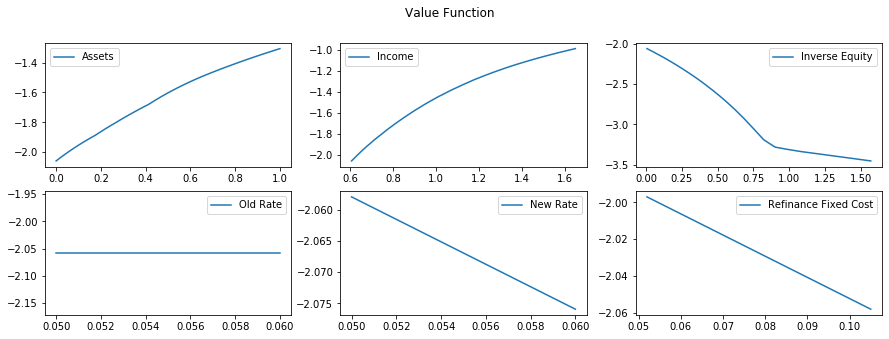

In [130]:
f, ax = plt.subplots(nrows = 2, ncols = 3, figsize = (15, 5))
ax[0, 0].plot(hh.anodes, v_star[:, 0, 0, 0, 0, 0], label = 'Assets')
ax[0, 1].plot(hh.ynodes, v_star[0, :, 0, 0, 0, 0], label = 'Income')
ax[0, 2].plot(hh.xnodes, v_star[0, 0, :, 0, 0, 0], label = 'Inverse Equity')
ax[1, 0].plot(hh.rmnodes, v_star[0, 0, 0, :, 0, 0], label = 'Old Rate')
ax[1, 1].plot(hh.rmnodes, v_star[0, 0, 0, 0, :, 0], label = 'New Rate')
ax[1, 2].plot(hh.Fnodes, v_star[0, 0, 0, 0, 0, :], label = 'Refinance Fixed Cost')
f.suptitle("Value Function")
for i in range(2):
    for j in range(3):
        ax[i,j].legend()
plt.show()

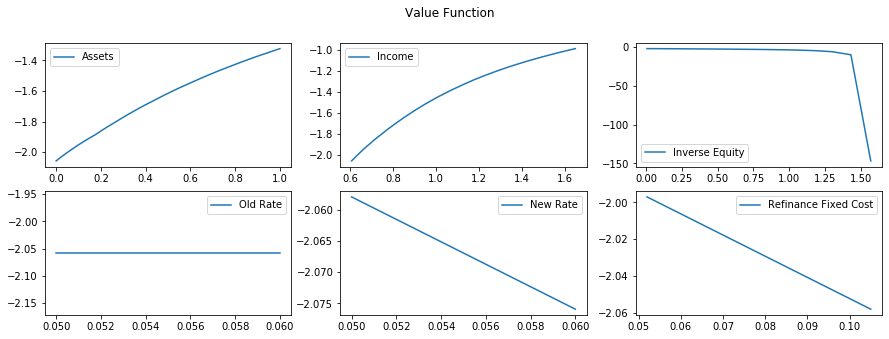

In [131]:
f, ax = plt.subplots(nrows = 2, ncols = 3, figsize = (15, 5))
ax[0, 0].plot(hh.anodes, vrefi_out[:, 0, 0, 0, 0, 0], label = 'Assets')
ax[0, 1].plot(hh.ynodes, vrefi_out[0, :, 0, 0, 0, 0], label = 'Income')
ax[0, 2].plot(hh.xnodes, vrefi_out[0, 0, :, 0, 0, 0], label = 'Inverse Equity')
ax[1, 0].plot(hh.rmnodes, vrefi_out[0, 0, 0, :, 0, 0], label = 'Old Rate')
ax[1, 1].plot(hh.rmnodes, vrefi_out[0, 0, 0, 0, :, 0], label = 'New Rate')
ax[1, 2].plot(hh.Fnodes, vrefi_out[0, 0, 0, 0, 0, :], label = 'Refinance Fixed Cost')
f.suptitle("Value Function - Refinance")
for i in range(2):
    for j in range(3):
        ax[i,j].legend()
plt.show()

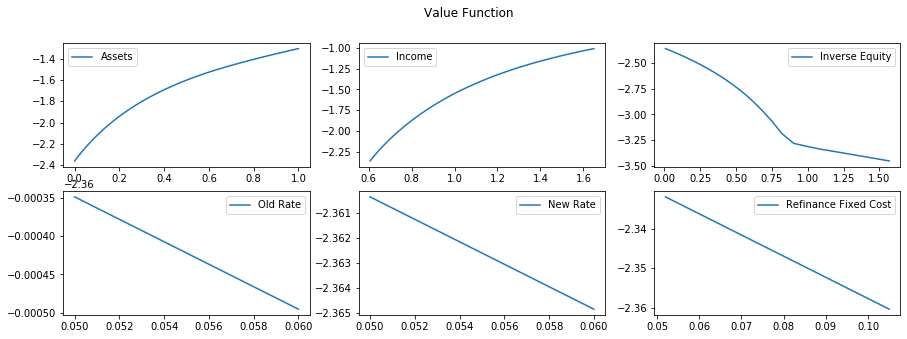

In [132]:
f, ax = plt.subplots(nrows = 2, ncols = 3, figsize = (15, 5))
ax[0, 0].plot(hh.anodes, vnorefi_out[:, 0, 0, 0, 0, 0], label = 'Assets')
ax[0, 1].plot(hh.ynodes, vnorefi_out[0, :, 0, 0, 0, 0], label = 'Income')
ax[0, 2].plot(hh.xnodes, vnorefi_out[0, 0, :, 0, 0, 0], label = 'Inverse Equity')
ax[1, 0].plot(hh.rmnodes, vnorefi_out[0, 0, 0, :, 0, 0], label = 'Old Rate')
ax[1, 1].plot(hh.rmnodes, vnorefi_out[0, 0, 0, 0, :, 0], label = 'New Rate')
ax[1, 2].plot(hh.Fnodes, vnorefi_out[0, 0, 0, 0, 0, :], label = 'Refinance Fixed Cost')
f.suptitle("Value Function - No Refinance")
for i in range(2):
    for j in range(3):
        ax[i,j].legend()
plt.show()

Getting consumption, refi choice, etc

In [133]:
%%time
refichoice, achoice, cchoice = get_policies(vrefi_out, vnorefi_out, pol_refi, pol_norefi)

Wall time: 797 ms


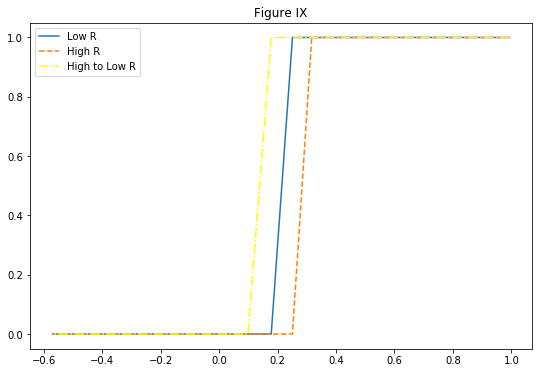

In [137]:
f_val=0
a_val=1
y_val=4
f, ax = plt.subplots(figsize = (9, 6))
ax.plot(1 - hh.xnodes, refichoice[a_val,y_val,:,0,0,f_val], label = 'Low R')
ax.plot(1 - hh.xnodes, refichoice[a_val,y_val,:,1,1,f_val], label = 'High R', linestyle = '--')
ax.plot(1 - hh.xnodes, refichoice[a_val,y_val,:,1,0,f_val], label = 'High to Low R', linestyle = '-.', color = 'yellow')
ax.set_title('Figure IX')
ax.legend()
plt.show()